<a href="https://colab.research.google.com/github/yatoyun/Authorship_analysis2023_A/blob/main/FinalProject/simple_feature_engg_notebook_spooky_author.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective of the competition:**

The competition dataset contains text from works of fiction written by spooky authors of the public domain: 
 1. Edgar Allan Poe (EAP)
 2. Others

 
The objective  is to accurately identify the author of the sentences in the test set.

**Objective of the notebook:**

In this notebook, let us try to create different features that will help us in identifying the spooky authors. 

As a first step, we will do some basic data visualization and cleaning before we delve deep into the feature engineering part.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/python_english

/content/drive/MyDrive/python_english


In [3]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline
nltk.download('stopwords')

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
## Read the train and test dataset and check the top few lines ##
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])
train_df['author'] = train_df['author'].replace(['MWS', 'HPL'], 'Others')

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [6]:
test_df.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


We can check the number of occurrence of each of the author to see if the classes are balanced. 

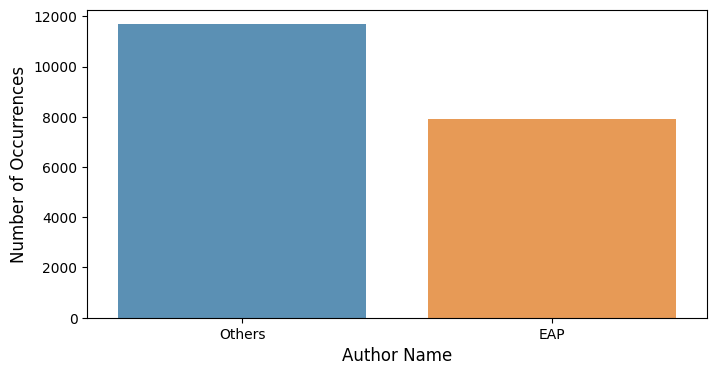

In [7]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

This looks good. There is not much class imbalance. Let us print some lines of each of the authors to try and understand their writing style if possible.

In [8]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

Only thing I can see is that there are quite a few special characters present in the text data. So count of these special characters might be a good feature. Probably we can create them later.

Apart from that, I do not have much clue.. In case if you find any interesting styles (features which we can create), please add them in the comments. 

**Feature Engineering:**

Now let us come try to do some feature engineering. This consists of two main parts.

 1. Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
 2. Text based features - features directly based on the text / words like frequency, svd, word2vec etc.

**Meta Features:**

We will start with creating meta featues and see how good are they at predicting the spooky authors. The feature list is as follows:
1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords 
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words


In [9]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

Let us now plot some of our new variables to see of they will be helpful in predictions.

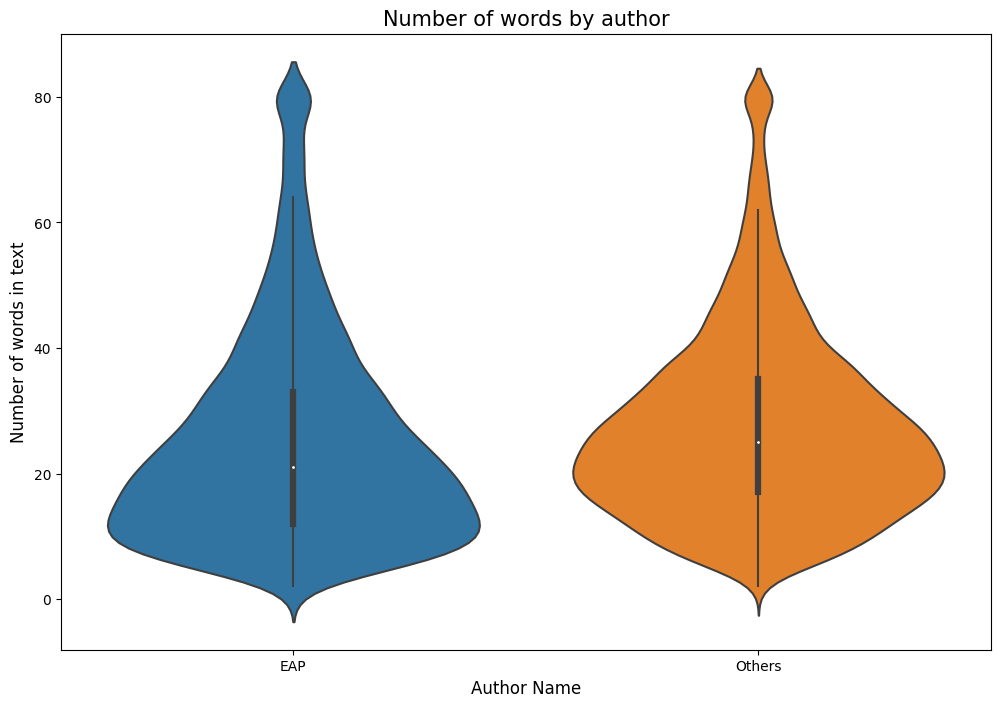

In [10]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

EAP seems slightly lesser number of words than Others. 

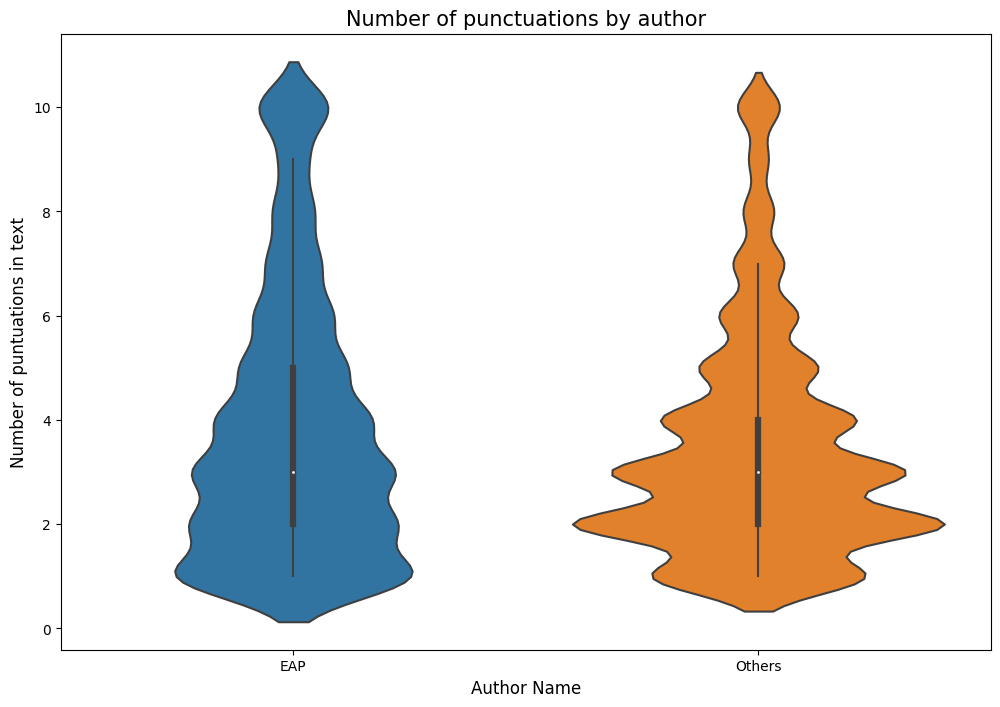

In [11]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

This also seems to be somewhat useful. Now let us focus on creating some text based features. 

Let us first build a basic model to see how these meta features  are helping. 

In [12]:
## Prepare the data for modeling ###
author_mapping_dict = {'EAP':0, 'Others':1}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

### recompute the trauncated variables again ###
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

We can train a simple XGBoost model with these meta features alone.

In [13]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 2
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

For the sake of kernel run time, we can just check the first fold in the k-fold cross validation for the scores. Please remove the 'break' line while running in local.

In [14]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[10:18:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mlogloss:0.68603	test-mlogloss:0.68589


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	train-mlogloss:0.64701	test-mlogloss:0.64615
[40]	train-mlogloss:0.63767	test-mlogloss:0.63881
[60]	train-mlogloss:0.63198	test-mlogloss:0.63480
[80]	train-mlogloss:0.62707	test-mlogloss:0.63129
[100]	train-mlogloss:0.62352	test-mlogloss:0.62880
[120]	train-mlogloss:0.62035	test-mlogloss:0.62761
[140]	train-mlogloss:0.61780	test-mlogloss:0.62656
[160]	train-mlogloss:0.61546	test-mlogloss:0.62582
[180]	train-mlogloss:0.61317	test-mlogloss:0.62499
[200]	train-mlogloss:0.61125	test-mlogloss:0.62453
[220]	train-mlogloss:0.60920	test-mlogloss:0.62439
[240]	train-mlogloss:0.60750	test-mlogloss:0.62405
[260]	train-mlogloss:0.60553	test-mlogloss:0.62371
[280]	train-mlogloss:0.60391	test-mlogloss:0.62355
[300]	train-mlogloss:0.60253	test-mlogloss:0.62338
[320]	train-mlogloss:0.60129	test-mlogloss:0.62319
[340]	train-mlogloss:0.59985	test-mlogloss:0.62321
[360]	train-mlogloss:0.59850	test-mlogloss:0.62319
[380]	train-mlogloss:0.59715	test-mlogloss:0.62310
[400]	train-mlogloss:0.59598	test-m

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


cv scores :  [0.6230364131427827]


We are getting a mlogloss of '0.987' using just the meta features. Not a bad score. Now let us see which of these features are important.

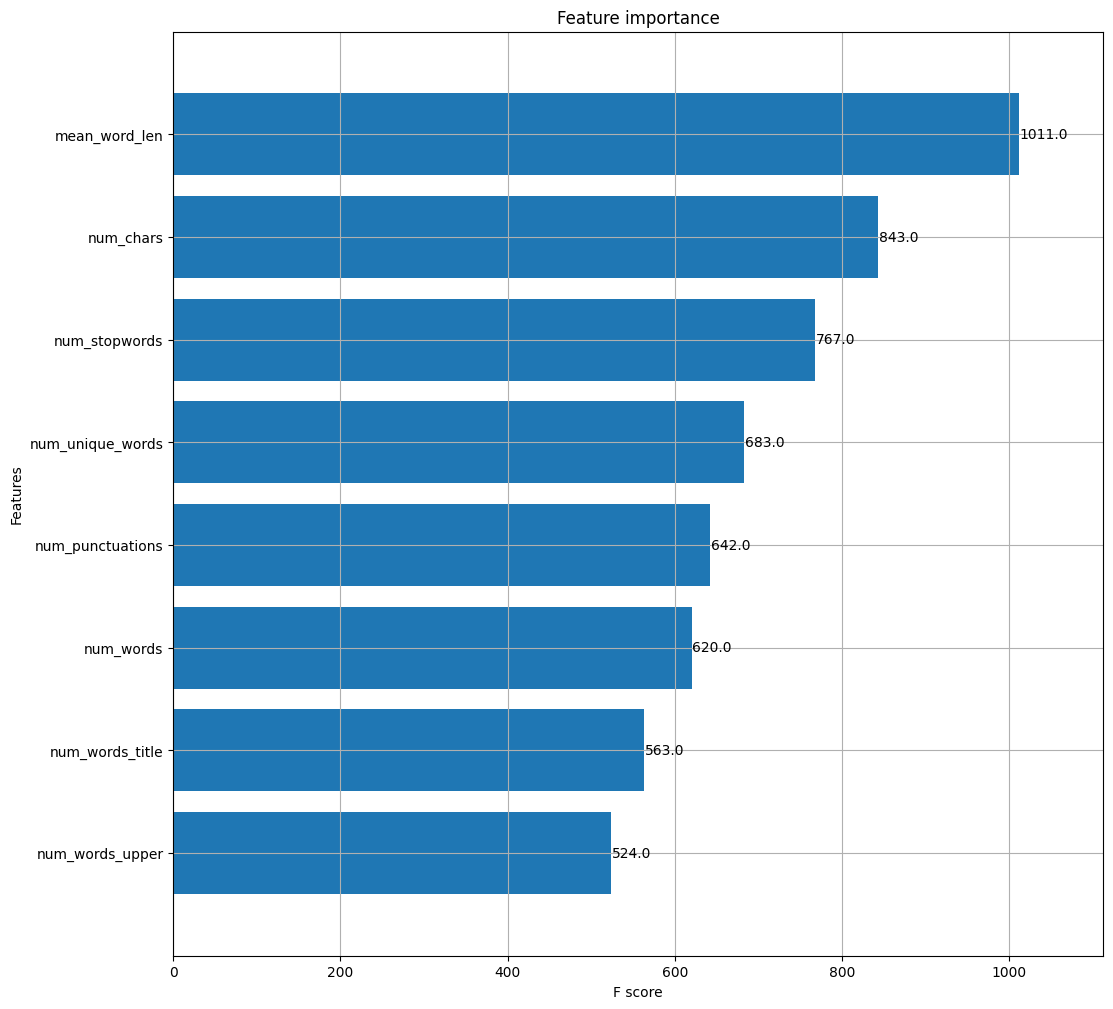

In [15]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Number of characters, mean word length and number of unique words turn out to be the top 3 variables. Now let us focus on creating some text based features. 

**Text Based Features :**

One of the basic features which we could create is tf-idf values of the words present in the text. So we can start with that one.


In [16]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

Now that we have got the tfidf vector, here is the tricky part. The tfidf output is a sparse matrix and so if we have to use it with other dense features, we have couple of choices. 
1. We can choose to get the top 'n' features (depending on the system config) from the tfidf vectorizer, convert it into dense format and concat with other features. 
2. Build a model using just the sparse features and then use the predictions as one of the features along with other dense features.

Based on the dataset, one might perform better than the other. Here we can use the second approach since there are some very [good scoring kernels](https://www.kaggle.com/the1owl/python-tell-tale-tutorial) using all the features of tfidf.

Also it seems that, [Naive Bayes is performing better](https://www.kaggle.com/thomasnelson/spooky-simple-naive-bayes-scores-0-399) in this dataset. So we could build a naive bayes model using tfidf features as it is faster to train.

In [17]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

**Naive Bayes on Word Tfidf Vectorizer:**

In [18]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.5346827286351303


We are getting a mlogloss of 0.844 using just tfidf vectorizer. Much better than the meta features. Let us look at the confusion matrix.

In [19]:
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

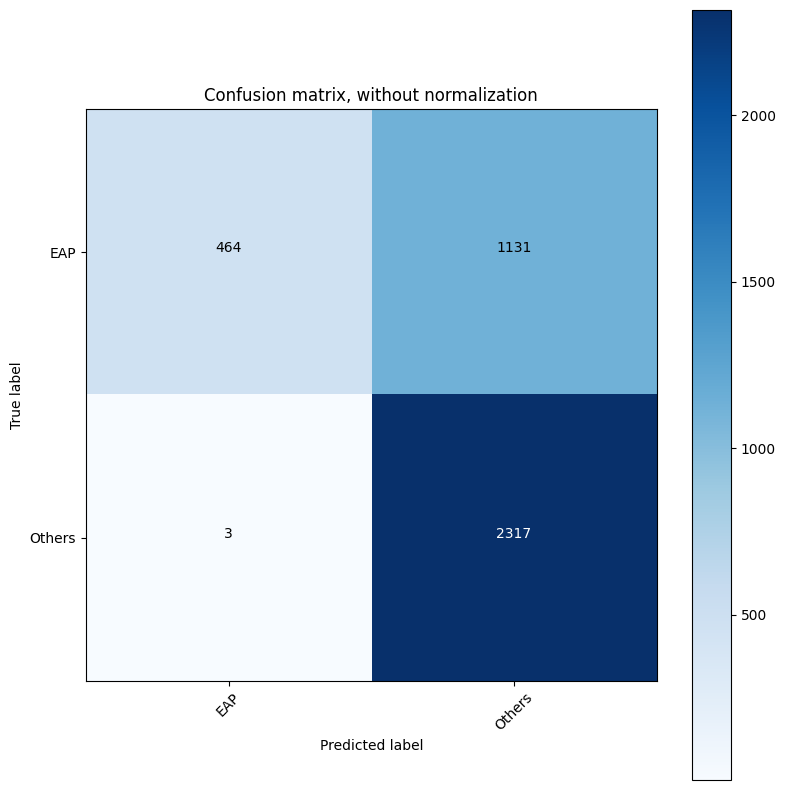

In [20]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'Others'],
                      title='Confusion matrix, without normalization')
plt.show()


So many instances are predicted as EAP and is highly biased towards that class. 

**SVD on word TFIDF:**

Since the tfidf vectors are sparse, one another way of compressing the information and representing it in a much compact way is through SVD. Also generally SVD features have performed well for me in the past text based competitions. So we could created svd features on word tfidf and add them to our feature set.

In [21]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

**Naive Bayes on Word Count Vectorizer:**

In [22]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

Now let us build Multinomial NB model using count vectorizer based features..

In [23]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_oth"] = pred_train[:,1]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_oth"] = pred_full_test[:,1]

Mean cv score :  0.35754062737194425


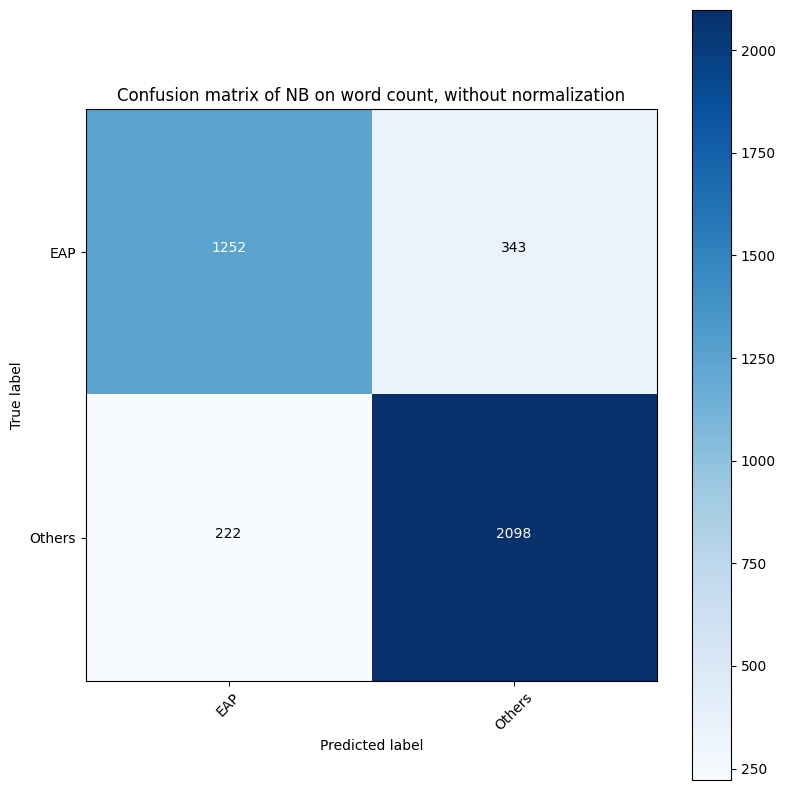

In [24]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'Others'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

Wow. We got a cross validation mlogloss of 0.451 using count vectorizer inplace of tfidf vectorizer. Also the confusion matrix looks much better than the previous one.

**Naive Bayes on Character Count Vectorizer:**

One idea from the "data eyeballing" is that counting the special charaters might help. Instead of just counting the special characters, we can use the count vectorizer at character level to get some features. Again we can run Multinomial NB on top of it.

In [25]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_oth"] = pred_train[:,1]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_oth"] = pred_full_test[:,1]

Mean cv score :  3.136005878265076


The cross val score is very high and is 3.75. But this might add some different information than word level features and so let us use this for the final model as well.

**Naive Bayes on Character Tfidf Vectorizer:**

Let us also get the naive bayes predictions on the character tfidf vectorizer.

In [26]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_oth"] = pred_train[:,1]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_oth"] = pred_full_test[:,1]

Mean cv score :  0.8952850613433817


**SVD on Character TFIDF:**

We could also create svd features on character tfidf features and used them for modeling.

In [27]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

**XGBoost model:**

Now with these new variables, we can re-run the xgboost model and evaluate the results.

In [28]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'Others']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[10:20:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mlogloss:0.63680	test-mlogloss:0.63556


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	train-mlogloss:0.28864	test-mlogloss:0.28283
[40]	train-mlogloss:0.25359	test-mlogloss:0.25203
[60]	train-mlogloss:0.23936	test-mlogloss:0.24300
[80]	train-mlogloss:0.22982	test-mlogloss:0.23840
[100]	train-mlogloss:0.22223	test-mlogloss:0.23567
[120]	train-mlogloss:0.21552	test-mlogloss:0.23380
[140]	train-mlogloss:0.20956	test-mlogloss:0.23205
[160]	train-mlogloss:0.20442	test-mlogloss:0.23113
[180]	train-mlogloss:0.19950	test-mlogloss:0.22986
[200]	train-mlogloss:0.19519	test-mlogloss:0.22981
[220]	train-mlogloss:0.19070	test-mlogloss:0.22927
[240]	train-mlogloss:0.18633	test-mlogloss:0.22813
[260]	train-mlogloss:0.18247	test-mlogloss:0.22821
[280]	train-mlogloss:0.17858	test-mlogloss:0.22809
[300]	train-mlogloss:0.17480	test-mlogloss:0.22825
[320]	train-mlogloss:0.17114	test-mlogloss:0.22811
[335]	train-mlogloss:0.16871	test-mlogloss:0.22824
cv scores :  [0.22795885745053546]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


**This has a val score of 0.2276 Running it on all the folds might give a better score. Now let us check the important variables again.

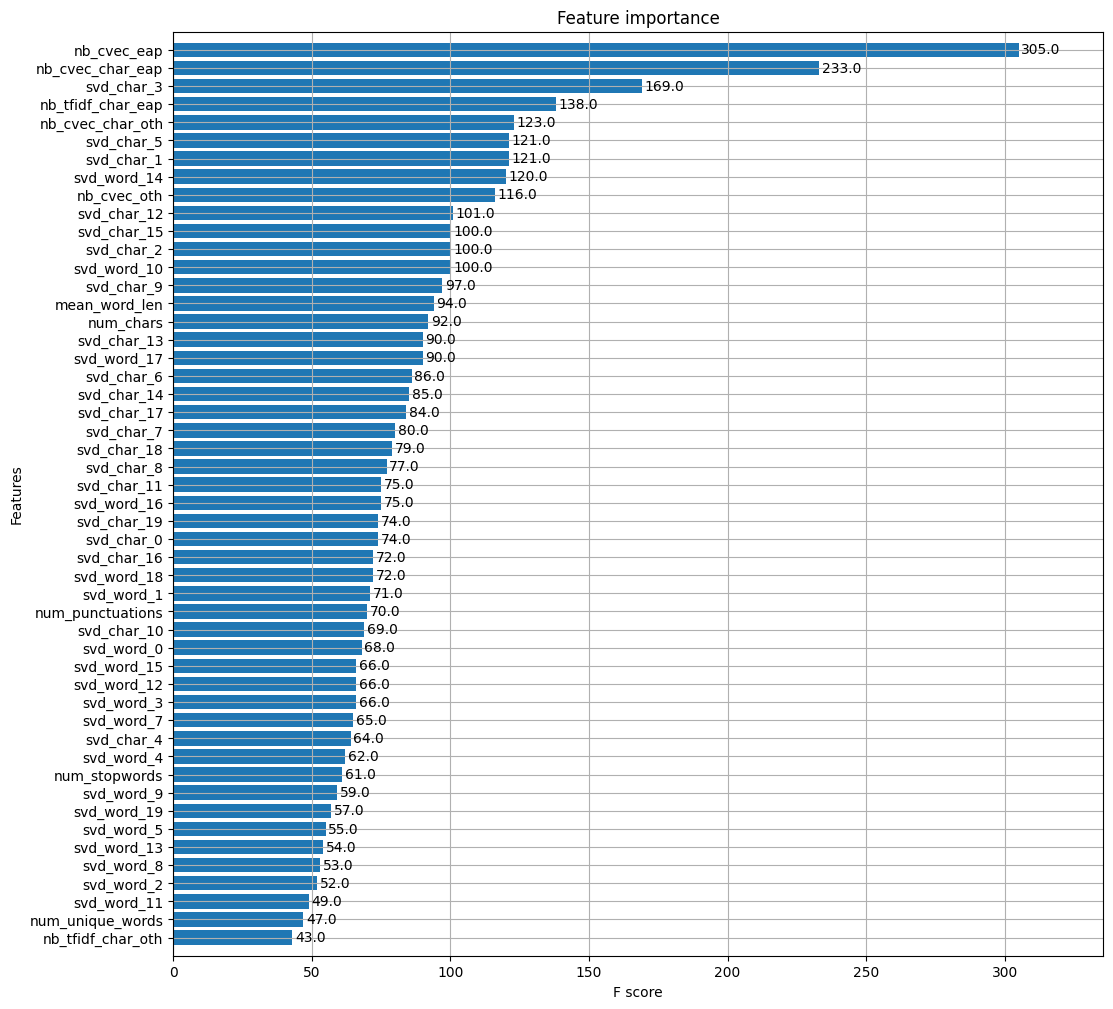

In [29]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Naive bayes features are the top features as expected. Now let us get the confusion matrix to see the misclassification errors.

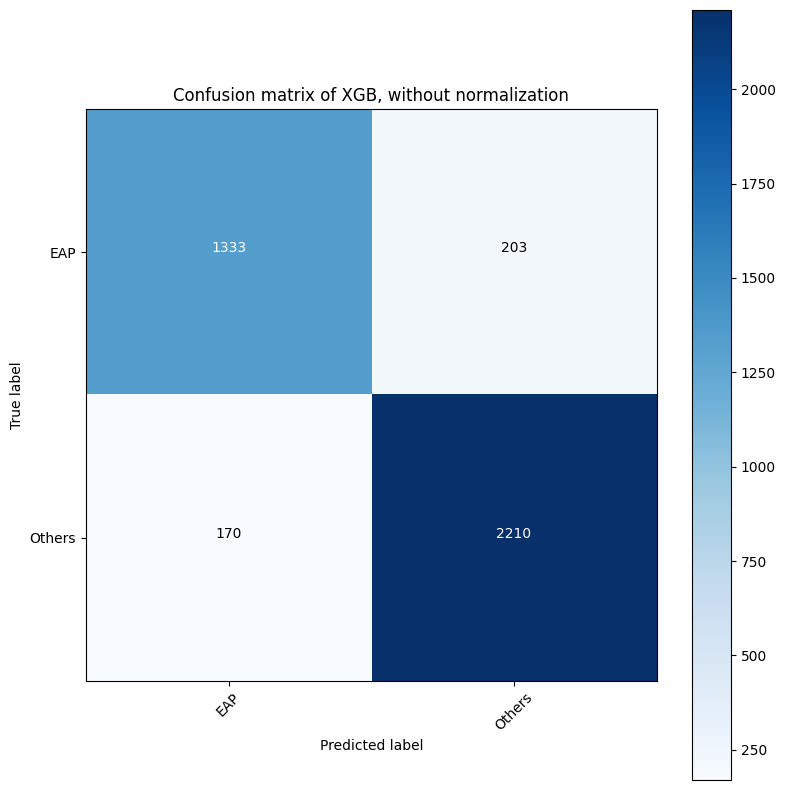

In [30]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'Others'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

# Our code

**Added code:**
* adjective classification
* passive-voice classification

In [31]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag

In [32]:
def analyze_adjective_usage(sentence):
    classification_adjective = 1 # 0 is not used adjective, 1 = attribute, -1 = predicate
    words = word_tokenize(sentence)
    tagged_words = pos_tag(words)

    for i, (word, pos) in enumerate(tagged_words):
        if pos == "JJ":
            if i + 1 < len(tagged_words) and tagged_words[i + 1][1] == "NN":
                classification_adjective *= 2
            elif i > 0 and tagged_words[i - 1][1] in {"VB", "VBD", "VBG", "VBN", "VBP", "VBZ"}:
                classification_adjective *= 3

    return classification_adjective

In [33]:
def isPassive(sentence):
    beforms = ["is", "am", "are", "was", "were", "been", "be", "being", "'s", "'m", "'re"]  # all forms of "be"
    aux = [
        "do",
        "did",
        "does",
        "have",
        "has",
        "had",
    ]  # NLTK tags "do" and "have" as verbs, which can be misleading in the following section.
    words = nltk.word_tokenize(sentence)
    tokens = nltk.pos_tag(words)
    tags = [i[1] for i in tokens]
    if tags.count("VBN") == 0:  # no PP, no passive voice.
        return 0
    elif tags.count("VBN") == 1 and "been" in words:  # one PP "been", still no passive voice.
        return 0
    else:
        pos = [
            i for i in range(len(tags)) if tags[i] == "VBN" and words[i] != "been"
        ]  # gather all the PPs that are not "been".
        for end in pos:
            chunk = tags[:end]
            start = 0
            for i in range(len(chunk), 0, -1):
                last = chunk.pop()
                if last == "NN" or last == "PRP":
                    start = i  # get the chunk between PP and the previous NN or PRP (which in most cases are subjects)
                    break
            sentchunk = words[start:end]
            tagschunk = tags[start:end]
            verbspos = [
                i for i in range(len(tagschunk)) if tagschunk[i].startswith("V")
            ]  # get all the verbs in between
            num_beforms = 0
            num_aux = 0
            if verbspos != []:  # if there are no verbs in between, it's not passive
                for i in verbspos:
                    if sentchunk[i].lower() in beforms:
                        num_beforms += 1
                    elif sentchunk[i].lower() in aux:
                        num_aux += 1
                    else:  # check if they are all forms of "be" or auxiliaries such as "do" or "have".
                        break
                else:
                    return (2 * num_beforms) * (3 * num_aux)
    return 0

In [34]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
train_df["adjective_usage"] = train_df["text"].apply(lambda x: analyze_adjective_usage(x))
test_df["adjective_usage"] = test_df["text"].apply(lambda x: analyze_adjective_usage(x))
train_df["passive"] = train_df["text"].apply(lambda x: isPassive(x))
test_df["passive"] = test_df["text"].apply(lambda x: isPassive(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [35]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'Others']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10:23:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mlogloss:0.63680	test-mlogloss:0.63556
[20]	train-mlogloss:0.28850	test-mlogloss:0.28258
[40]	train-mlogloss:0.25329	test-mlogloss:0.25140
[60]	train-mlogloss:0.23887	test-mlogloss:0.24239
[80]	train-mlogloss:0.22907	test-mlogloss:0.23765
[100]	train-mlogloss:0.22144	test-mlogloss:0.23530
[120]	train-mlogloss:0.21478	test-mlogloss:0.23328
[140]	train-mlogloss:0.20906	test-mlogloss:0.23239
[160]	train-mlogloss:0.20380	test-mlogloss:0.23123
[180]	train-mlogloss:0.19928	test-mlogloss:0.23009
[200]	train-mlogloss:0.19479	test-mlogloss:0.22998
[220]	train-mlogloss:0.19022	test-mlogloss:0.22936
[240]	train-mlogloss:0.18588	test-mlogloss:0.22865
[260]	train-mlogloss:0.18186	test-mlogloss:0.22868
[280]	train-mlogloss:0.17816	test-mlogloss:0.22837
[300]	train-mlogloss:0.17431	test-mlogloss:0.22793
[320]	train-mlogloss:0.17064	test-mlogloss:0.22778
[340]	train-mlogloss:0.16714	test-mlogloss:0.22748
[360

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


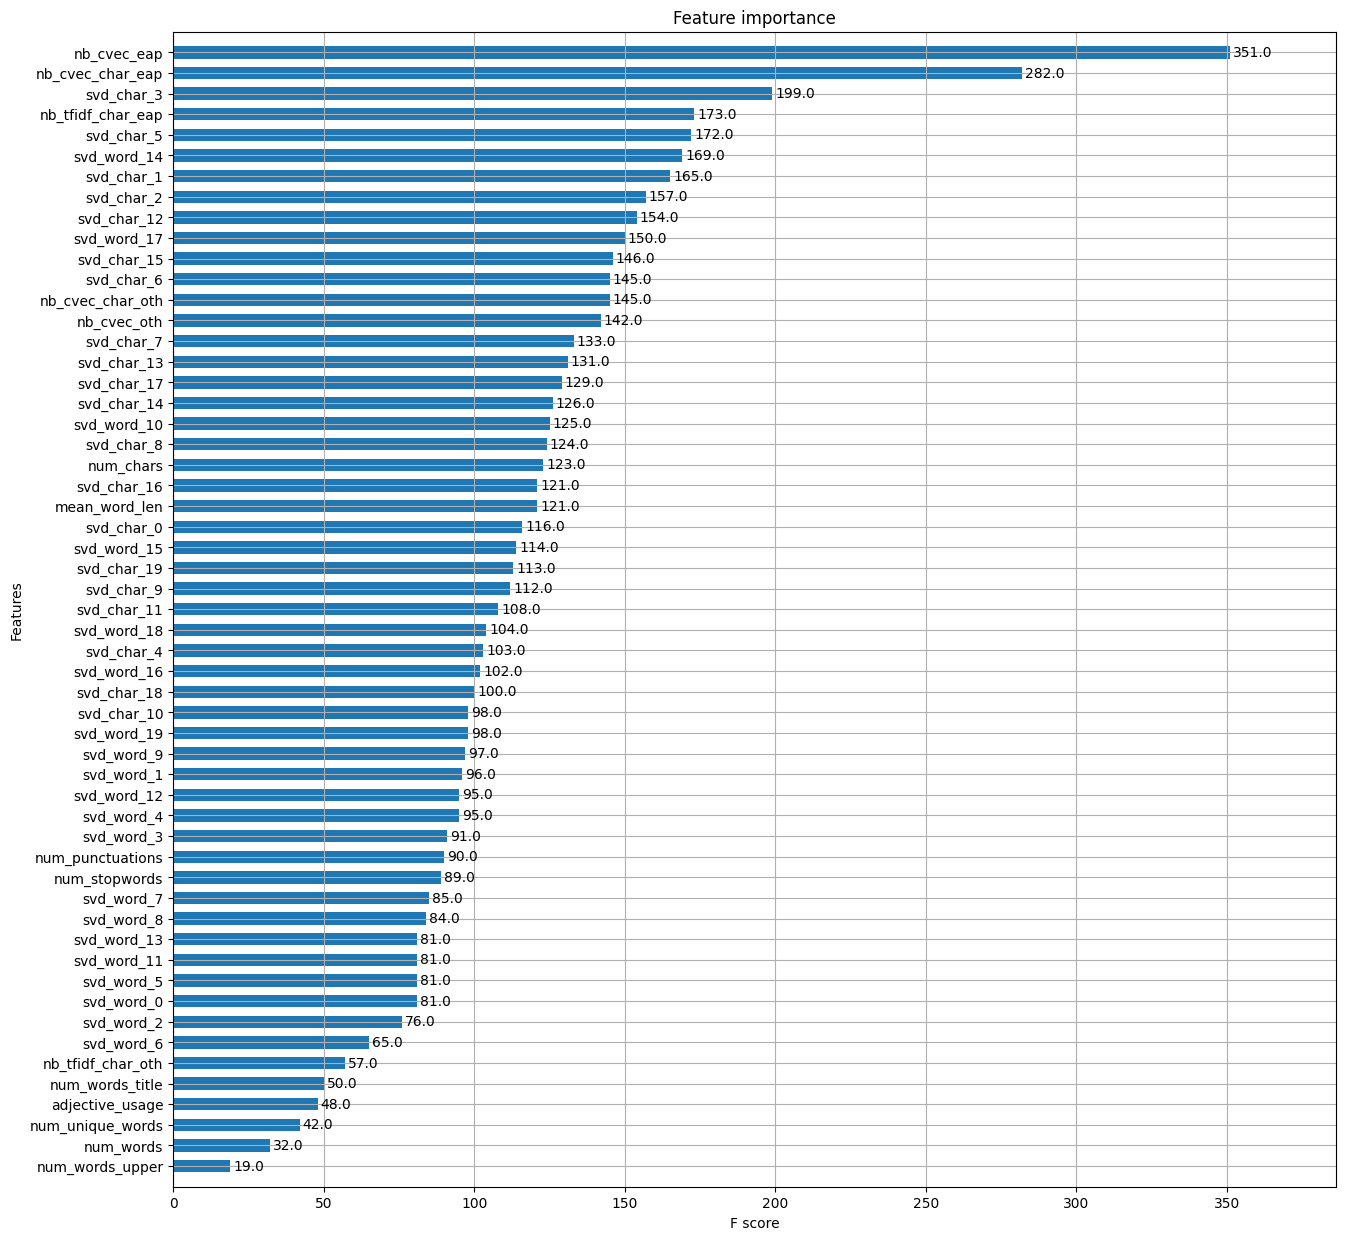

In [39]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(15,15))
xgb.plot_importance(model, max_num_features=200, height=0.6, ax=ax)
plt.show()

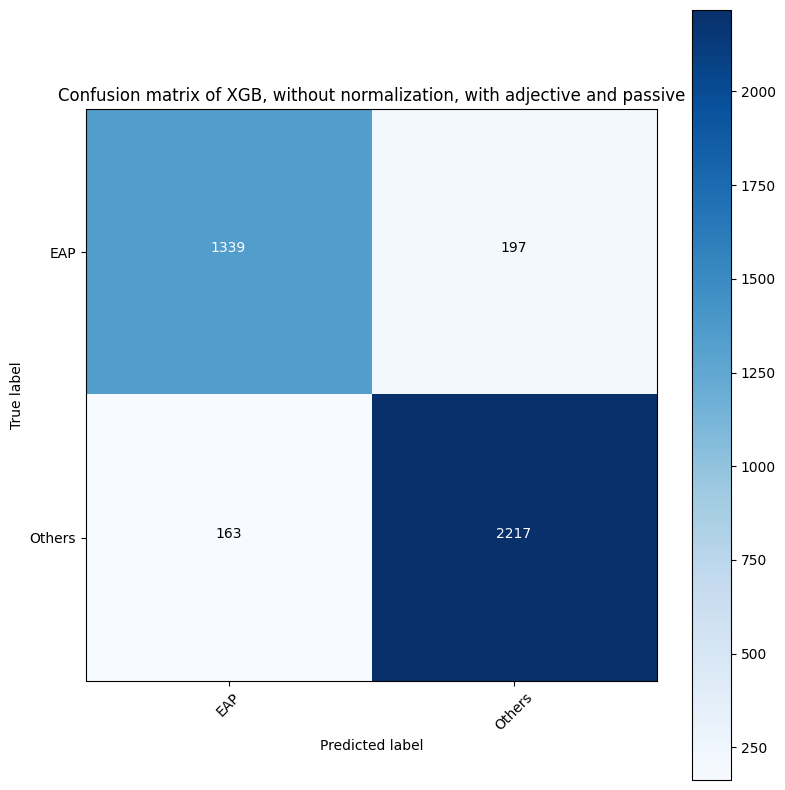

In [37]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'Others'],
                      title='Confusion matrix of XGB, without normalization, with adjective and passive')
plt.show()